In [55]:
import numpy as np
import matplotlib.pyplot as plt
import random
from functools import lru_cache

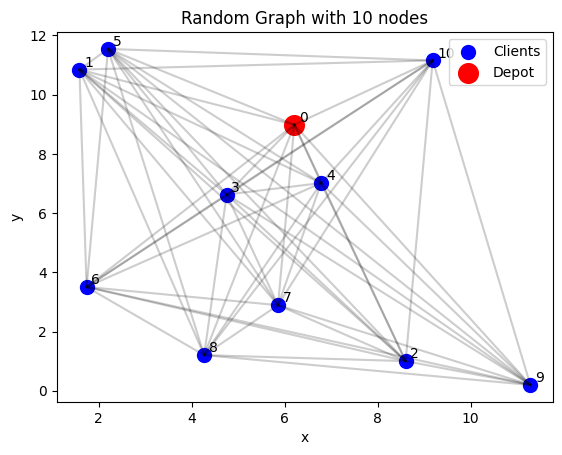

In [56]:
def generate_random_graph(n=10, weight_range=(1, 10)):
    """
    Generate a random graph with n nodes and random weights
    """
    xc = np.random.rand(n + 1)*12
    yc = np.random.rand(n + 1)*12

    # Generate initial traffic matrix
    adjacency_matrix = np.zeros((n + 1, n + 1))
    for i in range(n + 1):
        for j in range(n + 1):
            if i != j:
                adjacency_matrix[i, j] = np.sqrt((xc[i] - xc[j])**2 + (yc[i] - yc[j])**2)
                adjacency_matrix[j, i] = adjacency_matrix[i, j]

    return adjacency_matrix, xc, yc

n = 10 # Nombre de sommets
matrix, xc, yc = generate_random_graph(n)

plt.scatter(xc[1:], yc[1:], s=100, c='b', label="Clients")
plt.scatter(xc[0], yc[0], s=200, c='r', label="Depot")

# Draw edges
for i in range(n + 1):
    for j in range(n + 1):
        if i != j:
            plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='k', alpha=0.1)

# Annotations for nodes
for i in range(n + 1):
    plt.annotate(i, (xc[i] + 0.1, yc[i] + 0.1))

plt.title(f"Random Graph with {n} nodes")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

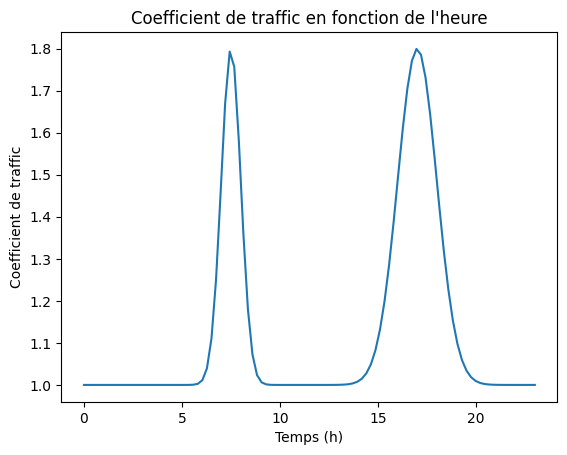

In [57]:
def traffic(x):
    return (0.8 * np.exp(-(x-7.5)**2 / (2 * 0.5**2)) + 0.8 * np.exp(-(x-17)**2 / (2 * 1**2))) + 1

x = np.linspace(0, 23, 100)
plt.plot(x, traffic(x))
plt.title("Coefficient de traffic en fonction de l'heure")
plt.xlabel("Temps (h)")
plt.ylabel("Coefficient de traffic")
plt.show()

# 1. Initialisation

Créez une population initiale. Cette population est généralement générée aléatoirement. Chaque individu, ou chromosome, dans cette population représente une solution possible au problème (dans ce cas, une séquence possible de livraisons pour les véhicules).

In [58]:
def create_individual(nb_truck, nb_client, starting_point=0):
    """
    Create a random individual
    """
    individual = {}
    clients = list(range(1, nb_client))
    random.shuffle(clients)
    
    groups = np.array_split(clients, nb_truck)
    for i, group in enumerate(groups):
        individual[i] = [starting_point] + list(group) + [starting_point]
    return individual

def individual_to_lists(individual):
    """
    Convert an individual to a list of lists
    """
    # For each truck, we create a list of clients
    nodes = []
    index = []

    for truck in individual:
        index_of_truck = len(nodes)
        index.append(index_of_truck)

        nodes_of_truck = individual[truck]
        nodes += nodes_of_truck[1:-1]

    return nodes, index

def individual_to_dict(individual_as_list, starting_point=0):
    """
    Convert an individual to a dict of lists
    """
    # For each truck, we create a list of clients
    nodes, index = individual_as_list
    individual = {}
    for i, truck in enumerate(index):
        if i == len(index) - 1:
            individual[i] = [starting_point] + nodes[truck:] + [starting_point] 
        else:
            individual[i] = [starting_point] + nodes[truck:index[i+1]] + [starting_point] 

    return individual

def create_population(nb_truck, nb_client, starting_point=0, size=100):
    """
    Create a population of individuals
    """
    population = []
    for i in range(size):
        population.append(create_individual(nb_truck, nb_client, starting_point))
    return population

population = create_population(3, 9, starting_point=0, size=10)
print(population)

[{0: [0, 4, 5, 2, 0], 1: [0, 7, 6, 8, 0], 2: [0, 1, 3, 0]}, {0: [0, 4, 2, 6, 0], 1: [0, 7, 8, 3, 0], 2: [0, 5, 1, 0]}, {0: [0, 1, 6, 5, 0], 1: [0, 3, 7, 4, 0], 2: [0, 2, 8, 0]}, {0: [0, 8, 1, 6, 0], 1: [0, 4, 3, 7, 0], 2: [0, 2, 5, 0]}, {0: [0, 3, 8, 2, 0], 1: [0, 1, 5, 6, 0], 2: [0, 4, 7, 0]}, {0: [0, 5, 2, 8, 0], 1: [0, 6, 7, 3, 0], 2: [0, 4, 1, 0]}, {0: [0, 8, 6, 2, 0], 1: [0, 3, 7, 1, 0], 2: [0, 4, 5, 0]}, {0: [0, 1, 2, 5, 0], 1: [0, 7, 8, 6, 0], 2: [0, 3, 4, 0]}, {0: [0, 5, 4, 8, 0], 1: [0, 6, 7, 2, 0], 2: [0, 3, 1, 0]}, {0: [0, 1, 2, 7, 0], 1: [0, 6, 8, 4, 0], 2: [0, 3, 5, 0]}]


# 2. Evaluation
Calculez la fonction de fitness pour chaque individu dans la population. La fonction de fitness détermine la qualité d'une solution. Dans le cas du VRP, cela pourrait être la distance totale parcourue par tous les véhicules.

In [59]:
def fitness(individual, adjency_matrix, departure_time):
    """
    Compute the fitness of an individual with traffic
    """
    fitness = 0        
    for truck in individual:
        start_time = departure_time
        for i in range(len(individual[truck])-1):
            weight = adjency_matrix[individual[truck][i]][individual[truck][i+1]]
            fitness += weight * traffic(start_time)
            start_time += (weight / 60)
    return fitness

# 3. Selection
Sélectionnez des individus pour la reproduction. Il existe plusieurs stratégies de sélection, comme la sélection par roulette (plus la fitness d'un individu est élevée, plus il a de chances d'être sélectionné) ou la sélection par tournoi (choisissez aléatoirement quelques individus et sélectionnez le meilleur parmi eux).

In [60]:
def selection(population, adjency_matrix, start_hour, k):
    """
    Select the best individuals in the population
    """
    population = sorted(population, key=lambda x: fitness(x, adjency_matrix, departure_time=start_hour))
    return population[:k]

# 4. Crossover
Créez une nouvelle génération de chromosomes en croisant les individus sélectionnés. Par exemple, en prenant la première moitié du chemin d'un parent et en complétant avec les villes restantes dans l'ordre qu'elles apparaissent dans le second parent.

In [61]:
def crossover(individu1, individu2):
    """
    Crossover between two individuals
    """
    # Transform both individuals into a list
    nodes_individu1, index_individu1 = individual_to_lists(individu1)
    nodes_individu2, index_individu2 = individual_to_lists(individu2)

    # Select a random crossover point
    crossover_point = random.randint(0, len(nodes_individu1)-1)

    # Create the new individuals
    new_individu1 = nodes_individu1[:crossover_point]
    new_individu2 = nodes_individu2[:crossover_point]

    # Add the remaining nodes in the order they appear in the other parent
    for node in nodes_individu2:
        if node not in new_individu1:
            new_individu1.append(node)
    
    for node in nodes_individu1:
        if node not in new_individu2:
            new_individu2.append(node)

    # Transform the new individuals into a dictionary
    new_individu1 = individual_to_dict((new_individu1, index_individu1))
    new_individu2 = individual_to_dict((new_individu2, index_individu2))

    return new_individu1, new_individu2

# 4. Mutation
Apportez de petites modifications aléatoires à certains individus dans la nouvelle génération. Par exemple, en échangeant deux villes dans l'itinéraire.

In [62]:
def mutation(individual, adjency_matrix):
    """
    Mutate an individual
    """
    # Transform the individual into a list
    nodes, index = individual_to_lists(individual)

    # We need to select two clients
    client1, client2 = random.sample(range(0, len(nodes)), 2)

    # We need to swap the two clients
    nodes[client1], nodes[client2] = nodes[client2], nodes[client1]

    # Transform the new individual into a dictionary
    individual = individual_to_dict((nodes, index))

    return individual

# 5. Remplacement
Remplacez l'ancienne population par la nouvelle génération d'individus.

In [91]:
def renew_population(population, adjency_matrix, mutation_rate, start_hour):
    """
    Renew the population
    """
    size_of_population = len(population)
    new_population = []

    while(len(new_population) < size_of_population):
        parent1, parent2 = random.sample(population, 2)
        child1, child2 = crossover(parent1, parent2)

        if random.random() < mutation_rate:
            child1 = mutation(child1, adjency_matrix)
        if random.random() < mutation_rate:
            child2 = mutation(child2, adjency_matrix)
        new_population.append(child1)
        new_population.append(child2)

    # Number of individuals to keep = percentage of individuals (between 0.3 and 0.7) * size of the population
    keep = int(random.uniform(0.3, 0.7) * size_of_population)

    best_individuals = selection(population + new_population, adjency_matrix, start_hour, k=keep)

    while(len(best_individuals) < size_of_population):
        best_individuals.append(create_individual(len(best_individual[0]), len(adjency_matrix), starting_point=0))

    return selection(population + new_population, adjency_matrix, start_hour, k=size_of_population)

# 6. Convergence
Vérifiez si l'algorithme a atteint un critère d'arrêt. Cela peut être un nombre maximum de générations, un temps d'exécution maximal, ou un seuil de fitness. Si le critère n'est pas atteint, revenez à l'étape 2.

In [64]:
def convergence(population, adjency_matrix, start_hour):
    """
    Check if the population has converged
    """
    # We need to check if all the individuals have the same fitness
    fitnesses = [fitness(individual, adjency_matrix, start_hour) for individual in population]
    return len(set(fitnesses)) == 1

# 7. Run

In [82]:
def plot_graph(adjency_matrix, xc, yc, routes, best_individual):
    """
    Plot two graphs :
        - The graph of the clients
        - The graph of the routes
    On each graph represent the starting point with a bigger red circle and the clients with blue circles
    Draw each routes on the second graph with different colors
    """
    # Create a list of colors
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    # Plot the graph of the clients
    ax[0].scatter(xc, yc, s=100, c='b')
    ax[0].scatter(xc[0], yc[0], s=200, c='r')
    ax[0].set_title("Clients")

    # Plot the graph of the routes
    ax[1].scatter(xc, yc, s=100, c='b')
    ax[1].scatter(xc[0], yc[0], s=200, c='r')
    ax[1].set_title("Routes")

    # Draw the routes
    for i, route in enumerate(routes):
        ax[1].plot(xc[best_individual[route]], yc[best_individual[route]], c=colors[i%len(colors)])

    # Annotation of the clients
    for i, txt in enumerate(range(len(xc))):
        ax[0].annotate(txt, (xc[i] + 0.1, yc[i] + 0.1))
        ax[1].annotate(txt, (xc[i] + 0.1, yc[i] + 0.1))

    plt.show()

def genetic_algorithm(adjency_matrix, nb_truck, start_hour=8, starting_point=0, population_size=100, mutation_rate=0.15):
    """
    Run the genetic algorithm
    """
    # Calculate the number of clients from the adjency matrix
    nb_client = len(adjency_matrix)

    # Create the initial population
    population = create_population(nb_truck, nb_client, starting_point, population_size)
    # While the population has not converged
    t = 0
    while not convergence(population, adjency_matrix, start_hour):
        # Renew the population
        population = renew_population(population, adjency_matrix, mutation_rate, start_hour)
        t += 1
        print("Iteration:", t, "Convergence:", convergence(population, adjency_matrix, start_hour=start_hour), "Best individual:", fitness(selection(population, adjency_matrix, start_hour=start_hour, k=1)[0], adjency_matrix, departure_time=start_hour))
    # Select the best individual
    best_individual = selection(population, adjency_matrix, start_hour,k=1)[0]
    
    print("-"*50)
    print("Number of iterations:", t)
    print("Best individual:", best_individual)
    print("Fitness:", fitness(best_individual, adjency_matrix, start_hour))
    print("-"*50)
    
    # Plot the graph
    plot_graph(adjency_matrix, xc, yc, best_individual, best_individual)

    return best_individual
    

Iteration: 1 Convergence: False Best individual: 81.76906207763177
Iteration: 2 Convergence: False Best individual: 80.30873485608244
Iteration: 3 Convergence: False Best individual: 80.30873485608244
Iteration: 4 Convergence: False Best individual: 80.30873485608244
Iteration: 5 Convergence: False Best individual: 80.30873485608244
Iteration: 6 Convergence: False Best individual: 80.30873485608244
Iteration: 7 Convergence: False Best individual: 80.30873485608244
Iteration: 8 Convergence: True Best individual: 80.30873485608244
--------------------------------------------------
Number of iterations: 8
Best individual: {0: [0, 9, 8, 0], 1: [0, 5, 4, 0], 2: [0, 1, 10, 0], 3: [0, 7, 6, 0], 4: [0, 3, 2, 0]}
Fitness: 80.30873485608244
--------------------------------------------------


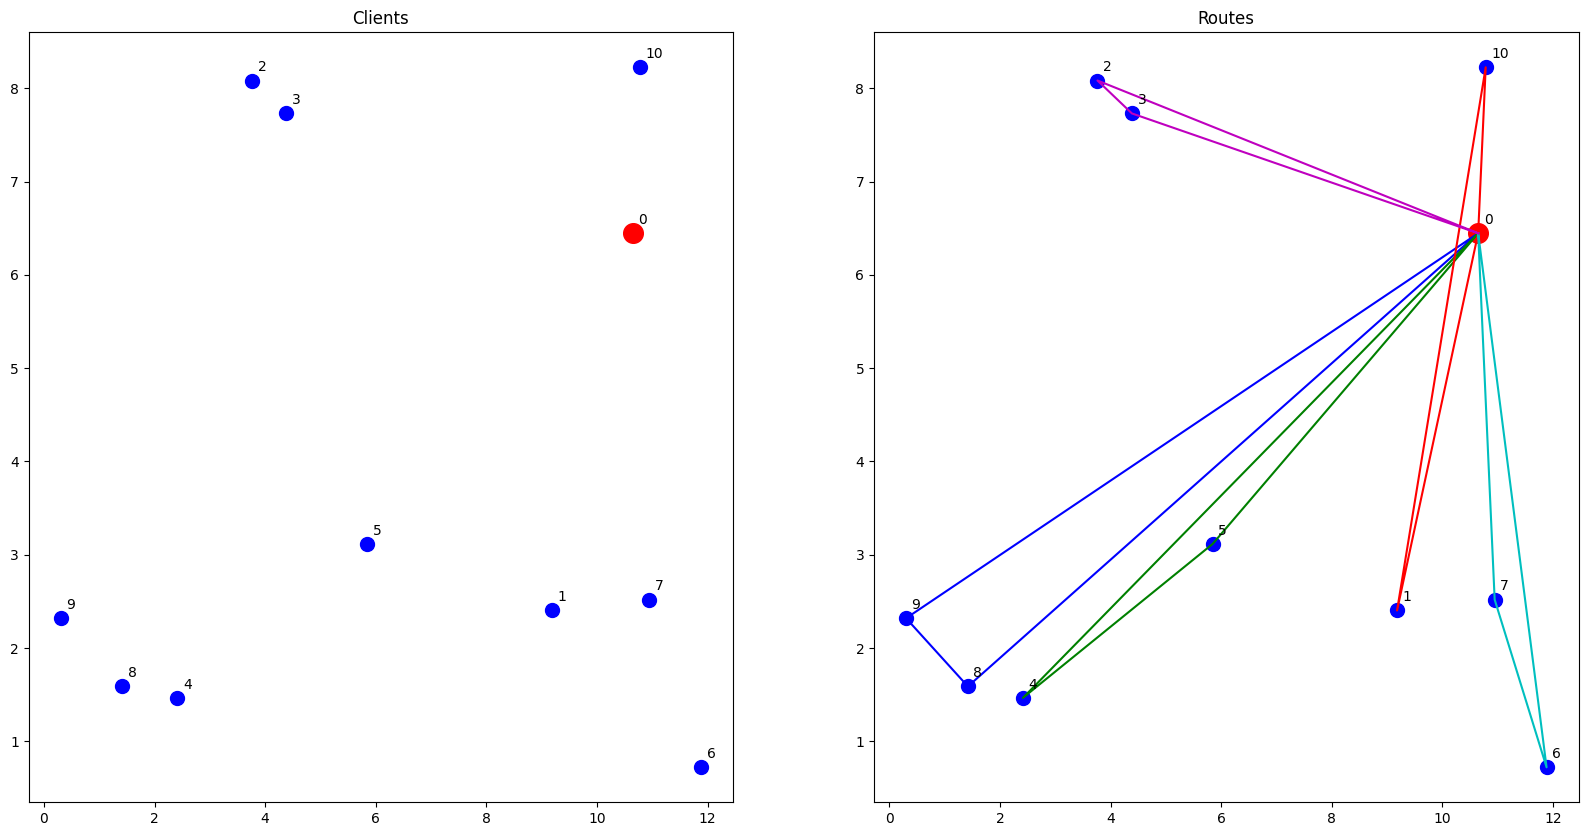

In [95]:
# --------------- Variables --------------- #
n = 10 # Number of clients
number_of_truck = 5 # Number of trucks
starting_point = 0 # Starting point
start_hour = 0 # Starting hour for the trucks

population_size = 30 # Size of the population generated by the genetic algorithm
mutation_rate = 0.30 # Mutation rate

# --------------- Main --------------- #
adjency_matrix, xc, yc = generate_random_graph(n)
best_individual = genetic_algorithm(adjency_matrix, nb_truck=number_of_truck, starting_point=starting_point, population_size=population_size, mutation_rate=mutation_rate, start_hour=start_hour)


In [96]:
import pulp
def distance(adjacency_matrix, i, j, h):
    """
    Compute the distance between two nodes i and j
    """
    return adjacency_matrix[i, j] * traffic(h)

K = number_of_truck

problem = pulp.LpProblem("VRPwTJ", pulp.LpMinimize)

# Variables de décision 
# x[i][j][k][h] = 1 si le véhicule k va du noeud i au noeud j à l'heure h
# y[i][k][h] = 1 si le véhicule k est au noeud i à l'heure h
x = [[[[pulp.LpVariable("x_{}_{}_{}_{}".format(i, j, k, h), cat="Binary") for h in range(0, 24)] for k in range(K)] for j in range(n + 1)] for i in range(n + 1)]
y = [[[pulp.LpVariable("y_{}_{}_{}".format(i, k, h), cat="Binary") for h in range(0, 24)] for k in range(K)] for i in range(n + 1)]

# Fonction objectif
problem += pulp.lpSum(distance(adjency_matrix, i, j, h) * x[i][j][k][h] for i in range(n+1) for j in range(n+1) for k in range(K) for h in range(0, 24))

# Contraintes

# Véhicule quitte le noeud dans lequel il entre
for i in range(n+1):
    for k in range(K):
        problem += pulp.lpSum(x[i][j][k][h] for j in range(n+1) for h in range(0, 24)) - pulp.lpSum(x[j][i][k][h] for j in range(n+1) for h in range(0, 24)) == 0

# Chaque client est visité une seule fois
for j in range(1, n+1):
    problem += pulp.lpSum(x[i][j][k][h] for i in range(n+1) for k in range(K) for h in range(0, 24)) == 1

# Chaque véhicule quitte le dépôt
for k in range(K):
    problem += pulp.lpSum(x[0][j][k][h] for j in range(1, n+1) for h in range(0, 24)) == 1

# Le véhicule quitte le dépôt à l'heure h = 0
for k in range(K):
    problem += pulp.lpSum(x[0][j][k][0] for j in range(1, n+1)) == 1

# Elimitation des sous-tours avec Dantzig, Fulkerson et Johnson
for i in range(1, n+1):
    for j in range(1, n+1):
        if i != j:
            for k in range(K):
                for h in range(0, 24):
                    problem += y[i][k][h] - y[j][k][h] + (n+1) * x[i][j][k][h] <= n

# Résolution
problem.solve()

# Affichage de la solution
print("Status:", pulp.LpStatus[problem.status])
print("Objective value:", pulp.value(problem.objective))

Status: Optimal
Objective value: 43.452650993478905


In [68]:
# Check if an individual is valid
def is_valid(individual, adjency_matrix, starting_point=0):
    dict_client = {i:0 for i in range(1, len(adjency_matrix))}
    is_valid = True

    for truck, trajet in individual.items():
        # Check if the cycle starts and ends at the starting point
        if trajet[0] != starting_point or trajet[-1] != starting_point:
            print("The cycle does not start and end at the starting point")
            is_valid = False
            break

        for vertice in trajet[1:-1]:
            dict_client[vertice] += 1

    # Check if all the clients are visited exactly once
    for client, nb_visits in dict_client.items():
        if nb_visits != 1:
            print("The client", client, "is visited", nb_visits, "times")
            is_valid = False
            break

    return is_valid

is_valid(best_individual, matrix)

True